In [4]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from utils.tracking_analysis.tracking_plotting import *
from set_global_params import raw_tracking_path, processed_data_path, bias_path
from utils.reaction_time_utils import get_bpod_trial_nums_per_session
from utils.post_processing_utils import get_all_experimental_records
from utils.post_processing_utils import remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.behaviour_utils import CalculateRBiasWindow

In [6]:
mouse = 'SNL_photo26' #example_mouse_used_in_paper
recording_site = 'tail'
bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))

In [10]:
all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='trial_nums', keep='first')


In [11]:
all_session_data

,Sound type,trial_nums,Trial type,State type,Instance in state,Max times in state,State name,Time start,Time end,Response,...,Last outcome,Trial start,Trial end,Trial outcome,First response,First choice correct,reaction_times,APE_peaks,trial_type,actual trial nums
0,10.0,0.0,1.0,1.0,1.0,1.0,TrialStart,17.9741,17.9841,1.0,...,-1.0,17.9741,105.4830,1.0,1.0,1.0,2.1301,3.098817,contra_data,737.0
9,10.0,1.0,7.0,1.0,1.0,1.0,TrialStart,105.7134,105.7234,2.0,...,1.0,105.7134,119.2539,1.0,2.0,1.0,0.4444,1.491182,ipsi_data,738.0
18,10.0,2.0,1.0,1.0,1.0,1.0,TrialStart,119.4172,119.4272,1.0,...,1.0,119.4172,124.2858,1.0,1.0,1.0,0.7490,1.594546,contra_data,739.0
26,10.0,3.0,1.0,1.0,1.0,1.0,TrialStart,124.4519,124.4619,1.0,...,1.0,124.4519,138.9796,1.0,2.0,0.0,NaN,NaN,NaN,740.0
34,10.0,4.0,1.0,1.0,1.0,1.0,TrialStart,139.1437,139.1537,1.0,...,1.0,139.1437,144.1054,1.0,2.0,0.0,NaN,NaN,NaN,741.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32172,NaN,552.0,7.0,1.0,1.0,1.0,TrialStart,3853.6938,3853.7038,2.0,...,1.0,3853.6938,3856.2712,1.0,2.0,1.0,0.5448,1.226479,ipsi_data,7585.0
32180,NaN,553.0,7.0,1.0,1.0,1.0,TrialStart,3856.4280,3856.4380,2.0,...,1.0,3856.4280,3859.3285,1.0,2.0,1.0,0.5095,0.696415,ipsi_data,7586.0
32188,NaN,554.0,7.0,1.0,1.0,1.0,TrialStart,3859.4752,3859.4852,2.0,...,1.0,3859.4752,3862.1542,1.0,2.0,1.0,0.5730,1.08449,ipsi_data,7587.0
32196,NaN,555.0,1.0,1.0,1.0,1.0,TrialStart,3862.3149,3862.3249,1.0,...,1.0,3862.3149,3865.6525,1.0,1.0,1.0,0.8476,1.763486,contra_data,7588.0


In [15]:
filtered_df = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]
contra_trial_type = filtered_df['Trial type'].unique()[0]

In [18]:
all_session_data = all_session_data.sort_values('actual trial nums').reset_index(drop=True)

In [1404]:
binary_last_choice = all_session_data['last choice'].replace({'ipsi': 0, 'contra': 1})
all_session_data['binary last choice'] = binary_last_choice

In [1405]:
contra_trials = all_session_data[(all_session_data['side'] == 'contra') & (all_session_data['outcome'] == 1) & (all_session_data['last trial type'] == contra_trial_type)].dropna()

In [1406]:
import statsmodels.api as sm
df = contra_trials
# Define the dependent variable (dopamine response size)
y = df['APE peaks']

# Define the independent variables
X = df[['binary last choice']]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              APE peaks   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     8.583
Date:                Tue, 27 Aug 2024   Prob (F-statistic):            0.00351
Time:                        19:31:53   Log-Likelihood:                -810.02
No. Observations:                 642   AIC:                             1624.
Df Residuals:                     640   BIC:                             1633.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.5870      0

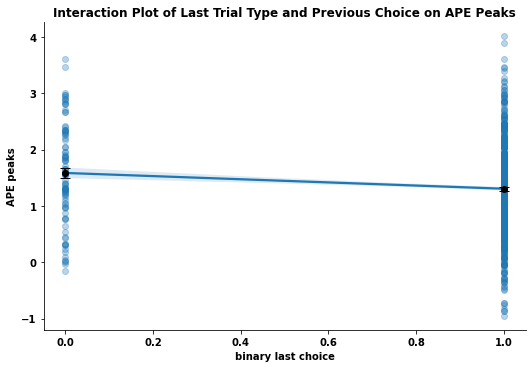

In [1407]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by 'binary last choice' and calculate mean and SEM
grouped = df.groupby('binary last choice').agg(
    mean_ape_peaks=('APE peaks', 'mean'),
    sem_ape_peaks=('APE peaks', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot the regression line with lmplot
sns.lmplot(x='binary last choice', y='APE peaks', data=df, aspect=1.5, ci=68, palette='viridis',  scatter_kws={'alpha':0.3} )

# Overlay error bars using plt.errorbar
plt.errorbar(x=grouped['binary last choice'], 
             y=grouped['mean_ape_peaks'], 
             yerr=grouped['sem_ape_peaks'], 
             fmt='o', color='black', capsize=5)

plt.title('Interaction Plot of Last Trial Type and Previous Choice on APE Peaks')
plt.show()



In [1413]:
import pandas as pd
import statsmodels.api as sm
df = all_session_data


# Step 4: Filter for trials where the current side is 'contra'
df['previous stim same'] = df['last trial type'] == df['trial type']
df['previous stim same'] = df['previous stim same'].astype(int)
df_contra = df[(df['side'] == 'contra') & (df['trial type'] == contra_trial_type)].dropna()

# Step 5: Run the regression separately for each trial type and store coefficients
coefficients = {}


df_trial = df_contra[df_contra['previous stim same'] == 1]
# Define predictors and response

X = df_trial['binary last choice']
X = sm.add_constant(X)  # Add a constant term to the model
y = df_trial['APE peaks']
    
# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              APE peaks   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     8.583
Date:                Tue, 27 Aug 2024   Prob (F-statistic):            0.00351
Time:                        19:34:06   Log-Likelihood:                -810.02
No. Observations:                 642   AIC:                             1624.
Df Residuals:                     640   BIC:                             1633.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.5870      0

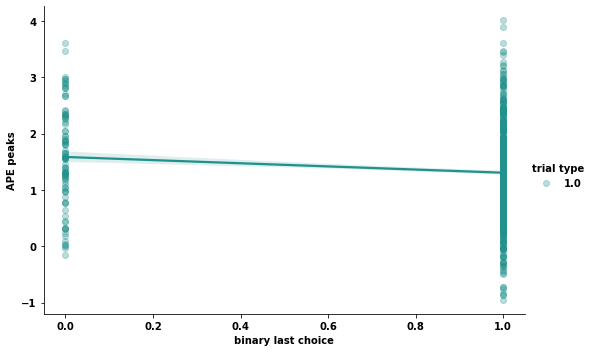

In [1414]:
sns.lmplot(x='binary last choice', y='APE peaks', data=df_trial, hue='trial type', aspect=1.5, ci=68, palette='viridis',  scatter_kws={'alpha':0.3} )


In [1424]:
trial_num_diffs.unique()

array([  2., 517., 547.,   3., 443., 355., 357., 404.,   4., 278.])

(array([170.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

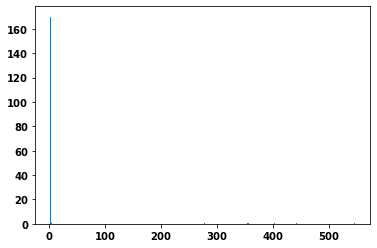

In [1423]:
trial_num_diffs = df['actual trial numbers'].diff()
trial_num_diffs = trial_num_diffs[trial_num_diffs > 1]
plt.hist(trial_num_diffs, bins=500)

In [1328]:
import pandas as pd
import statsmodels.api as sm
df = all_session_data[['trial type', 'side', 'APE peaks', 'actual trial numbers']].set_index('actual trial numbers')

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


def shift_according_to_index(df, col_to_shift, lag):
    # Shift the 'value' column by 1
    df['shifted_value'] = df[col_to_shift].shift(lag)

    return df['shifted_value'].where(df.index.to_series().diff() == df.index.to_series().diff().shift(-lag))

# Assuming your dataframe is named `df`


# Step 2: Specify the number of lags you want to create
num_lags = 1  # You can change this number to include more or fewer lags

# Step 3: Create lagged variables dynamically using a loop
for lag in range(1, num_lags + 1):
    df[f'previous_stim_same{lag}'] = shift_according_to_index(df, 'trial type', lag) == df['trial type']
    df[f'previous_stim_same{lag}'] = df[f'previous_stim_same{lag}'].astype(int)
    df[f'previous_side{lag}'] = shift_according_to_index(df, 'side', lag).replace({'ipsi': 0, 'contra': 1})

# Step 4: Filter for trials where the current side is 'contra'
df_contra = df[(df['side'] == 'contra')].dropna()

# Step 5: Run the regression separately for each trial type and store coefficients
coefficients = {}


df_trial = df_contra[df_contra['previous_stim_same1'] == 1]
    
# Define predictors and response
lagged_columns = [f'previous_side{lag}' for lag in range(1, num_lags + 1)]
X = df_trial[lagged_columns]
X = sm.add_constant(X)  # Add a constant term to the model
y = df_trial['APE peaks']
    
# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              APE peaks   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8447
Date:                Tue, 27 Aug 2024   Prob (F-statistic):              0.359
Time:                        19:07:32   Log-Likelihood:                -459.78
No. Observations:                 364   AIC:                             923.6
Df Residuals:                     362   BIC:                             931.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3368      0.134      9.

In [1331]:
df.columns


Index(['max speed', 'average speed', 'time to max speed', 'speeds',
       'max acceleration', 'average acceleration', 'time to max acceleration',
       'accelerations', 'APE peaks', 'time to move', 'trial numbers', 'traces',
       'head x', 'head y', 'head angles', 'angular velocity',
       'max angular velocity', 'time to max angular vel', 'cumsum ang vel',
       'max cumsum ang vel', 'time to max cum sum ang vel', 'max initial turn',
       'angular acceleration', 'turn slopes', 'turn starts', 'sig x', 'sig y',
       'sig mse', 'movement dir', 'distance travelled', 'last 10 x',
       'last 10 y', 'fitted max cumsum ang vel', 'area under sigmoid',
       'trial type', 'reaction times', 'side', 'choice numeric',
       'actual trial numbers', 'last trial type', 'last outcome',
       'last choice', 'next trial type', 'next outcome', 'next choice',
       'next choice numeric', 'stay or switch', 'outcome', 'APE quantile',
       'date', 'binary last choice'],
      dtype='object'

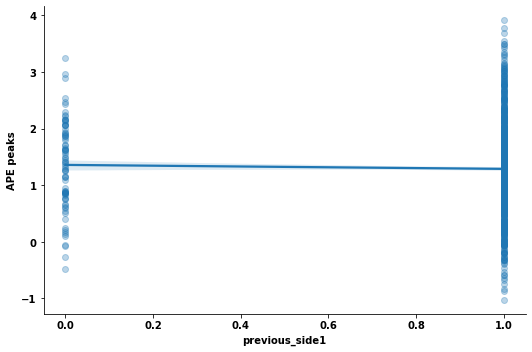

In [1321]:
# Plot the regression line with lmplot
sns.lmplot(x='previous_side1', y='APE peaks', data=df_trial, aspect=1.5, ci=68, palette='viridis',  scatter_kws={'alpha':0.3} )


In [1314]:
results.pvalues[1:]

previous_side1    0.493288
dtype: float64

In [1298]:
df

,trial type,side,APE peaks,previous_stim_same1,previous_side1
0,1.0,contra,2.109809,0,NaN
1,7.0,ipsi,1.376390,0,contra
2,7.0,ipsi,1.286027,1,ipsi
3,1.0,ipsi,1.049806,0,ipsi
4,7.0,contra,1.610897,0,ipsi
...,...,...,...,...,...
2260,1.0,contra,-0.327791,0,ipsi
2261,1.0,contra,1.572306,1,contra
2262,7.0,ipsi,1.186244,0,contra
2263,1.0,contra,0.847835,0,ipsi


In [1290]:
contra_trial_type

1.0

In [1229]:
X

,const,prev_APE_peaks,trial type,prev_side_ipsi,prev_side_trial_type
1,1.0,1.543621,7.0,0,0.0
3,1.0,0.316041,1.0,1,1.0
4,1.0,2.655635,7.0,0,0.0
6,1.0,0.151094,7.0,1,7.0
7,1.0,1.026863,1.0,0,0.0
...,...,...,...,...,...
3049,1.0,2.547466,1.0,1,1.0
3050,1.0,0.270133,1.0,0,0.0
3053,1.0,1.080882,1.0,1,1.0
3058,1.0,1.084490,1.0,1,1.0


In [1216]:
df

,trial type,side,APE peaks,prev_choice,prev_APE_peaks
0,7.0,contra,1.543621,NaN,NaN
1,7.0,contra,3.380248,contra,1.543621
2,7.0,ipsi,0.316041,contra,3.380248
3,1.0,contra,2.655635,NaN,NaN
4,7.0,contra,2.819108,ipsi,0.316041
...,...,...,...,...,...
3055,7.0,ipsi,1.226479,ipsi,-0.193226
3056,7.0,ipsi,0.696415,ipsi,1.226479
3057,7.0,ipsi,1.084490,ipsi,0.696415
3058,1.0,contra,1.763486,contra,0.429587


In [999]:
# Step 1: Create a boolean mask where both columns have zeros
wrong_habit_mask = (all_session_data['binary last choice'] == 0) & (all_session_data['last outcome'] == 0)

wrong_habit_rolling_mean = wrong_habit_mask.rolling(window=5).mean()

right_habit_mask = (all_session_data['binary last choice'] == 1) & (all_session_data['last outcome'] == 1)

right_habit_rolling_mean = right_habit_mask.rolling(window=5).mean()
bias =  wrong_habit_rolling_mean -right_habit_rolling_mean

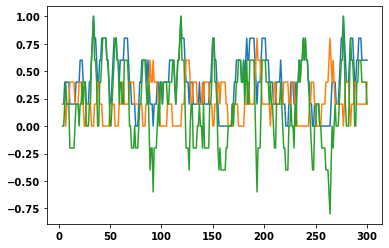

In [1000]:
plt.plot(wrong_habit_rolling_mean)
plt.plot(right_habit_rolling_mean)
plt.plot(bias)


In [1001]:
all_session_data['wrong habit'] = wrong_habit_rolling_mean
all_session_data['right habit'] = right_habit_rolling_mean
all_session_data['bias'] = bias

In [1002]:
contra_trials = all_session_data[(all_session_data['side'] == 'contra') & (all_session_data['outcome'] == 1)]
ipsi_trials = all_session_data[all_session_data.side == 'ipsi']

(array([ 1.,  2., 13., 12., 16.,  0., 19., 13.,  3.,  3.]),
 array([-0.6 , -0.44, -0.28, -0.12,  0.04,  0.2 ,  0.36,  0.52,  0.68,
         0.84,  1.  ]),
 <BarContainer object of 10 artists>)

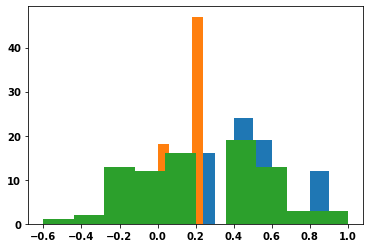

In [1003]:
plt.hist(contra_trials['wrong habit']
        )
plt.hist(contra_trials['right habit'])
plt.hist(contra_trials['bias'])

In [1004]:
mean_wrong_habit = contra_trials['wrong habit'].mean()
std_wrong_habit = contra_trials['wrong habit'].std()
biggest_wrong_habit_trials = contra_trials[contra_trials['wrong habit'] >= mean_wrong_habit + std_wrong_habit]
smallest_wrong_habit_trials = contra_trials[contra_trials['wrong habit'] < mean_wrong_habit - std_wrong_habit]

In [1005]:
mean_wrong_habit

0.44878048780487784

(array([1., 2., 3., 0., 0., 1., 3., 1., 1., 1.]),
 array([0.48993541, 0.77972647, 1.06951752, 1.35930858, 1.64909963,
        1.93889069, 2.22868174, 2.5184728 , 2.80826385, 3.09805491,
        3.38784596]),
 <BarContainer object of 10 artists>)

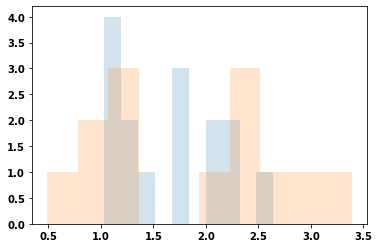

In [995]:
plt.hist(biggest_wrong_habit_trials['APE peaks'].values, alpha=0.2)
plt.hist(smallest_wrong_habit_trials['APE peaks'].values, alpha=0.2)

In [996]:
stats.ttest_ind(biggest_wrong_habit_trials['APE peaks'].values, smallest_wrong_habit_trials['APE peaks'].values)

Ttest_indResult(statistic=-0.6114537791147721, pvalue=0.5462088821107844)

In [997]:
1

1

C:\Users\francescag\AppData\Local\Temp\ipykernel_6612\4211575454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling mean APE'] = df['APE peaks'].rolling(window=1).mean()
C:\Users\francescag\AppData\Local\Temp\ipykernel_6612\4211575454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] =df[key].rolling(window=1).mean()


<AxesSubplot:xlabel='actual trial number', ylabel='wrong habit'>

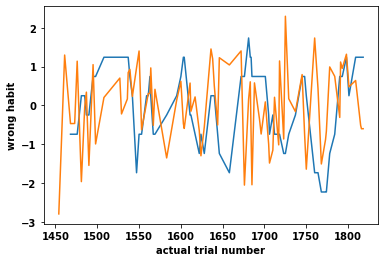

In [998]:
key = 'abs fitted max cumsum ang vel'
df = contra_trials[['APE peaks', 'wrong habit', key]]
df['rolling mean APE'] = df['APE peaks'].rolling(window=1).mean()
df[key] =df[key].rolling(window=1).mean()
normalized_df=(df-df.mean())/df.std()
normalized_df['actual trial number'] = contra_trials['actual trial numbers']
sns.lineplot(data=normalized_df, x='actual trial number', y='wrong habit')
sns.lineplot(data=normalized_df, x='actual trial number', y='rolling mean APE')
#plt.plot(normalized_df[key])

In [881]:
df = ipsi_trials[['APE peaks', 'bias']]
df['rolling mean APE'] = df['APE peaks'].rolling(window=10).mean()
normalized_df=(df-df.mean())/df.std()
plt.plot(normalized_df.bias)
plt.plot(normalized_df['rolling mean APE'])

KeyError: "['bias'] not in index"

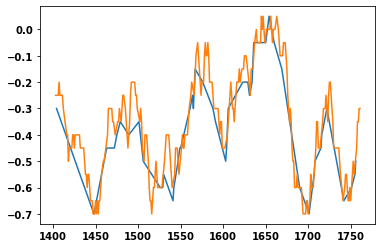

In [636]:
plt.plot(contra_trials['actual trial numbers'], contra_trials.bias)
plt.plot(ipsi_trials['actual trial numbers'], ipsi_trials.bias)

In [983]:

# Drop NaN values that result from the rolling operation
rolling_mean_contra = normalized_df['wrong habit'].dropna()

# Align the continuous series with the rolling mean series by matching indices
aligned_continuous_series_contra = normalized_df['APE peaks'].loc[rolling_mean_contra.index]
aligned_continuous_series_contra = aligned_continuous_series_contra.dropna()
rolling_mean_contra = rolling_mean_contra.loc[aligned_continuous_series_contra.index]
# Perform regression (adding a constant for the intercept)
X = sm.add_constant(rolling_mean_contra)
model = sm.OLS(aligned_continuous_series_contra, X)
results = model.fit()

# Display the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              APE peaks   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.003
Date:                Tue, 27 Aug 2024   Prob (F-statistic):              0.320
Time:                        11:52:52   Log-Likelihood:                -111.70
No. Observations:                  82   AIC:                             227.4
Df Residuals:                      80   BIC:                             232.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0340      0.106      0.322      

In [856]:

# Drop NaN values that result from the rolling operation
rolling_mean_ipsi = ipsi_trials.bias.dropna()

# Align the continuous series with the rolling mean series by matching indices
aligned_continuous_series_ipsi = ipsi_trials['APE peaks'].loc[rolling_mean_ipsi.index]

# Perform regression (adding a constant for the intercept)
X = sm.add_constant(rolling_mean_ipsi)
model = sm.OLS(aligned_continuous_series_ipsi, X)
results = model.fit()

# Display the regression results
print(results.summary())

AttributeError: 'DataFrame' object has no attribute 'bias'

C:\Users\francescag\AppData\Local\Continuum\miniconda3\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='APE peaks', ylabel='wrong habit'>

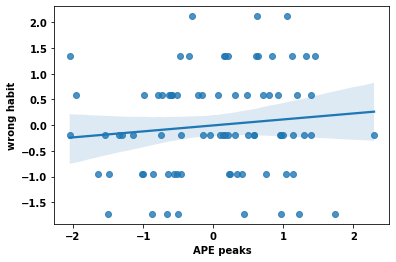

In [984]:

sns.regplot(aligned_continuous_series_contra, rolling_mean_contra)

In [548]:
all_session_data.columns

Index(['max speed', 'average speed', 'time to max speed', 'speeds',
       'max acceleration', 'average acceleration', 'time to max acceleration',
       'accelerations', 'APE peaks', 'time to move', 'trial numbers', 'traces',
       'head x', 'head y', 'head angles', 'angular velocity',
       'max angular velocity', 'time to max angular vel', 'cumsum ang vel',
       'max cumsum ang vel', 'time to max cum sum ang vel', 'max initial turn',
       'angular acceleration', 'turn slopes', 'turn starts', 'sig x', 'sig y',
       'sig mse', 'movement dir', 'distance travelled', 'last 10 x',
       'last 10 y', 'fitted max cumsum ang vel', 'area under sigmoid',
       'trial type', 'reaction times', 'side', 'choice numeric',
       'actual trial numbers', 'last trial type', 'last outcome',
       'last choice', 'next trial type', 'next outcome', 'next choice',
       'next choice numeric', 'stay or switch', 'outcome', 'APE quantile',
       'date', 'abs fitted max cumsum ang vel', 'bias'],
 

In [652]:
contra_trials[contra_trials['bias'] <np.nanmean(contra_trials.bias)]['APE peaks'].mean()

1.879472364700156

In [653]:
contra_trials[contra_trials['bias'] >= np.nanmean(contra_trials.bias)]['APE peaks'].mean()

1.81943572115545

In [638]:
np.nanmax(contra_trials.bias)

0.04999999999999999

(array([4., 9., 5., 9., 4., 7., 6., 2., 5., 3.]),
 array([-0.7  , -0.625, -0.55 , -0.475, -0.4  , -0.325, -0.25 , -0.175,
        -0.1  , -0.025,  0.05 ]),
 <BarContainer object of 10 artists>)

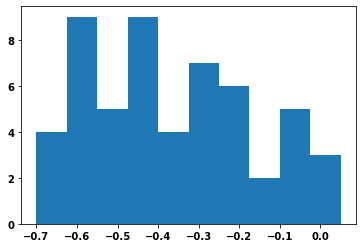

In [642]:
plt.hist(contra_trials.bias
        )